In [239]:
import cv2
import numpy as np
from skimage import io, morphology
import matplotlib.pyplot as plt
import imageio

In [240]:
# Normalize between 0 and 1, then multiply by 255
def normalize_img(image, dtype=np.uint8):
    image = image.astype(float)
    image -= np.amin(image.astype(float))
    image /= np.amax(image)
    image *= 255
    return image.astype(dtype)

In [241]:
def resize_stack(input_stack, new_size=(512, 512)):
    assert len(new_size) == 2, "new_size must be a len=2 tuple or list."
    assert len(input_stack.shape) == 3, "input_array array must be 3-dimensional"

    # Pre-allocate the resized array with the new dimensions
    resized_stack = np.zeros((input_stack.shape[0], new_size[1], new_size[0]), dtype=input_stack.dtype)

    # Iterate over each timepoint and each slice
    for z in range(input_stack.shape[0]):  # Loop over slices
        # COnvert to np.uint8, then resize slice and add it to new array

        slice = input_stack[z,:,:].astype(np.uint8)
        slice = cv2.resize(input_stack[z,:,:], new_size, interpolation=cv2.INTER_LINEAR)
        resized_stack[z,:,:] = slice

    return resized_stack

In [242]:
def set_black(image, dtype=np.uint8):
    
    window = image[:250,:250]
    black_pt = np.mean(window)

    # Set all pixels below the black point to zero
    thresholded_image = np.maximum(image, black_pt)

    # Adjust the scale of other pixels
    scale_factor = 255 / (255 - black_pt)
    adjusted_image = (thresholded_image - black_pt) * scale_factor
    adjusted_image = np.clip(adjusted_image, 0, 255).astype(np.uint8)

    return adjusted_image

In [243]:
def sigmoid_adjustment(image, std_mult=1.5, alpha=.5):

    # Get mean and standard deviation of image
    mean_val = np.mean(image)
    std_dev = np.std(image)

    # Set the midpoint for the sigmoid function to 1 standard deviation above the mean * arbitrary multiplier
    midpoint = mean_val + std_dev * std_mult

    # Apply the sigmoid function to adjust image contrast
    # 'alpha' controls the steepness of the sigmoid curve
    adjusted_image = 1 / (1 + np.exp(-alpha * (image - midpoint)))

    # Scale back to 0-255 and convert to uint8
    adjusted_image = np.uint8(255 * (adjusted_image - adjusted_image.min()) / (adjusted_image.max() - adjusted_image.min()))

    return adjusted_image

In [244]:
def mask_slice(image, mask):
    image *= mask
    return image

In [245]:
def threshold_slice(image, threshold=0, cleaned=False, min_size=4):
    canvas = np.ones_like(image)
    image = np.where(image > threshold, canvas, 0)

    if cleaned:
        binary_img = image > 0
        image = morphology.remove_small_objects(binary_img, min_size, connectivity=2)
        
    return image

In [246]:
# Function to apply an arbitrary process to each slice in a stack
def process_stack(input_stack, process_func, *args, **kwargs):

    output_stack = np.zeros_like(input_stack)

    for z in range(input_stack.shape[0]):
        slice = input_stack[z,:,:]
        output_stack[z,:,:] = process_func(slice, *args, **kwargs)

    return output_stack

In [247]:
def visualize_slices(processed_stack, preview_slices):

    # Determine the number of subplots needed
    num_slices = len(preview_slices)
    num_rows = int(np.ceil(np.sqrt(num_slices)))
    num_cols = int(np.ceil(num_slices / num_rows))
    
    # Create subplots
    fig, axs = plt.subplots(num_rows, num_cols, figsize=(12, 12))
    axs = axs.ravel()  # Flatten the axis array if necessary

    # Display each slice in its subplot
    for i, slice_idx in enumerate(preview_slices):
        slice_img = processed_stack[slice_idx, :, :]
        axs[i].imshow(slice_img, cmap='gray')
        axs[i].set_title(f'Slice {slice_idx}')
        axs[i].axis('off')  # Optional: remove axes for cleaner look

    # Adjust layout to prevent overlap
    plt.tight_layout()
    plt.show()

In [248]:
# Load image stack
timepoint = 3

stack = io.imread('stacks/exp240202_01_E.tif')
input_stack = stack[timepoint,:,:,:]
del stack

In [249]:
# Normalize between 0-255
norm_stack = process_stack(input_stack, normalize_img)
#input_stack = process_stack(input_stack, cv2.convertScaleAbs, alpha=1, beta=-50)


In [250]:
# Set black point to average background color
black_stack = process_stack(norm_stack, set_black)
print(np.amin(black_stack[16,:,:]))
print(np.amax(black_stack[16,:,:]))

0
255


In [251]:
# Pull out signal using sigmoid
processed_stack = process_stack(black_stack, sigmoid_adjustment, std_mult=3, alpha=1) 

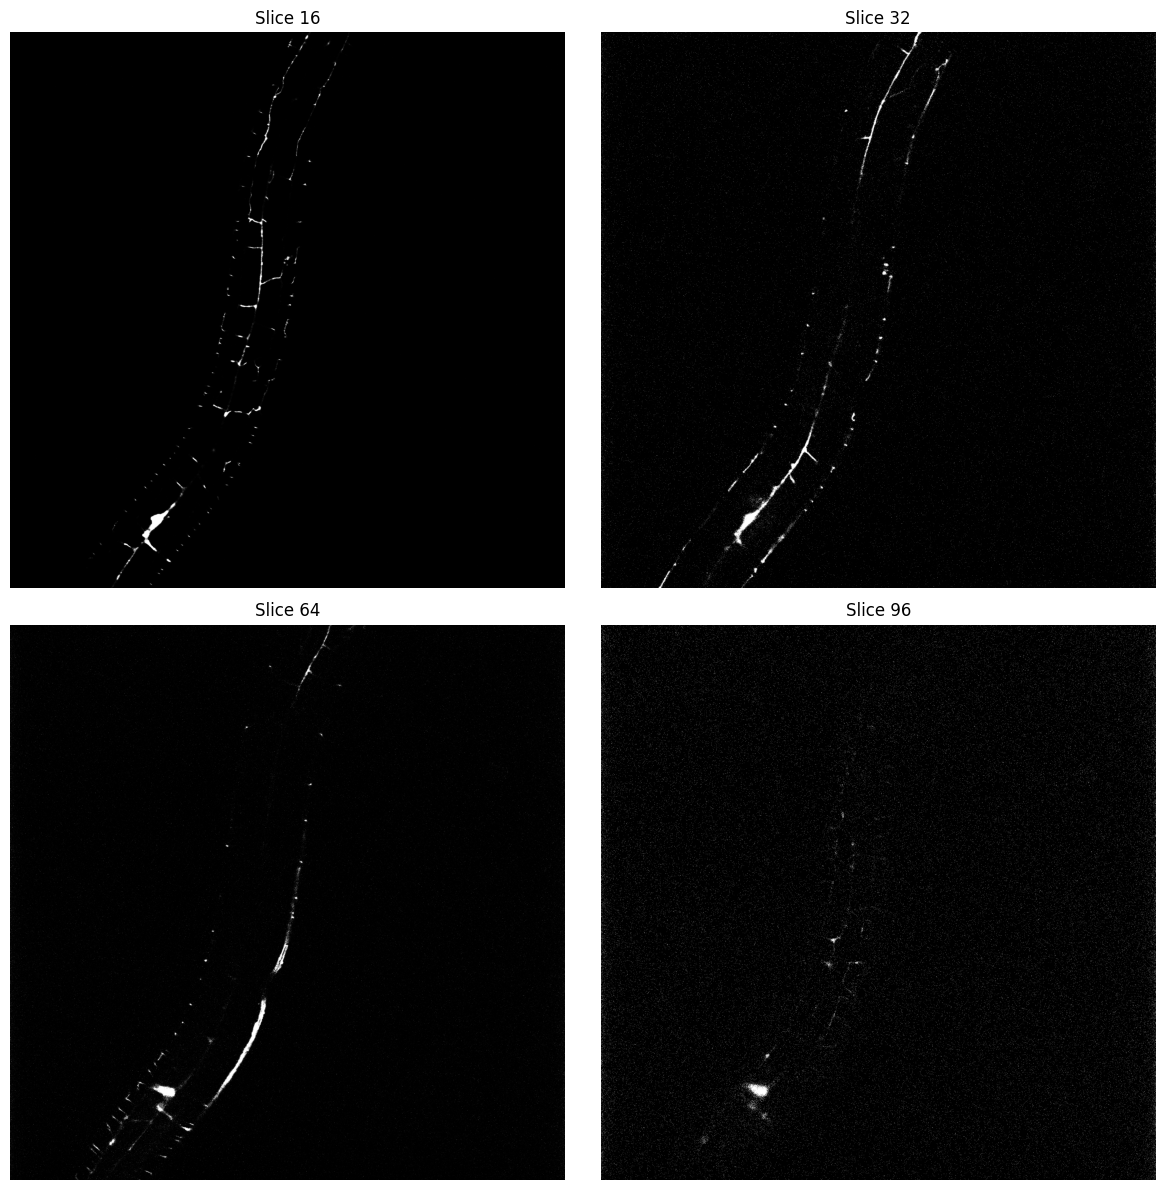

In [252]:
# Visualize
preview_slices = [16, 32, 64, 96]
visualize_slices(processed_stack, preview_slices)


### Create MIP Mask

In [253]:
mip_image = np.max(input_stack, axis=0)
canvas = np.ones_like(mip_image)
mip_mask = np.where(normalize_img(mip_image) >= 4, canvas, 0)
np.amax(mip_mask)

# Dilate
mip_mask = morphology.binary_dilation(mip_mask, morphology.disk(radius=3))

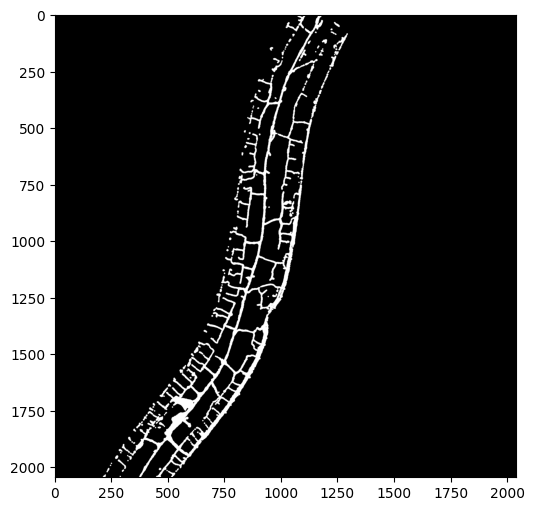

In [254]:
fig, ax = plt.subplots(figsize=(6, 6))
ax.imshow(mip_mask, cmap='gray')

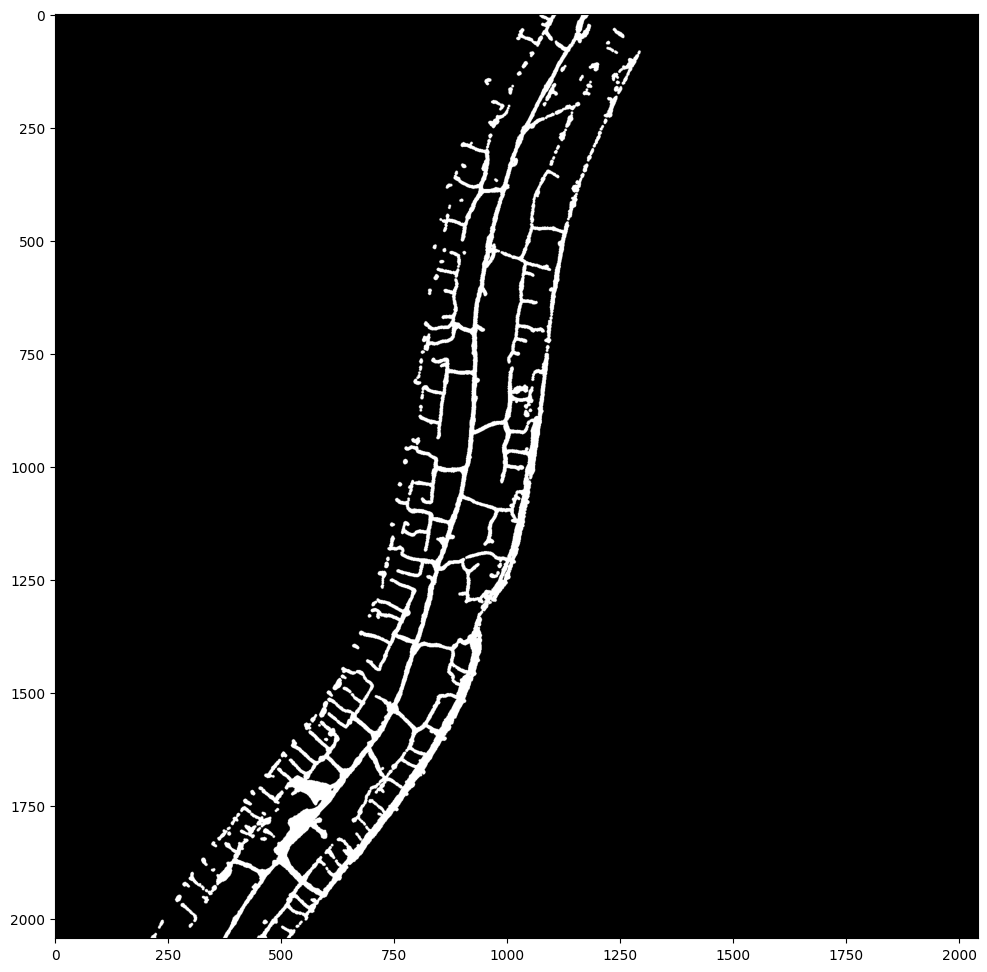

In [255]:
# Remove small objects (optional)
from skimage import morphology

binary_img = mip_mask > 0
cleaned_mask = morphology.remove_small_objects(binary_img, min_size=48, connectivity=4)

# Display the result
fig, ax = plt.subplots(figsize=(12, 12))
ax.imshow(cleaned_mask, cmap='gray')

In [256]:
# Save mask
imageio.imwrite('output/mip_mask.tif', cleaned_mask.astype(np.uint8))

### Final Threshold

In [257]:
masked_stack = process_stack(processed_stack, mask_slice, mask=mip_mask)

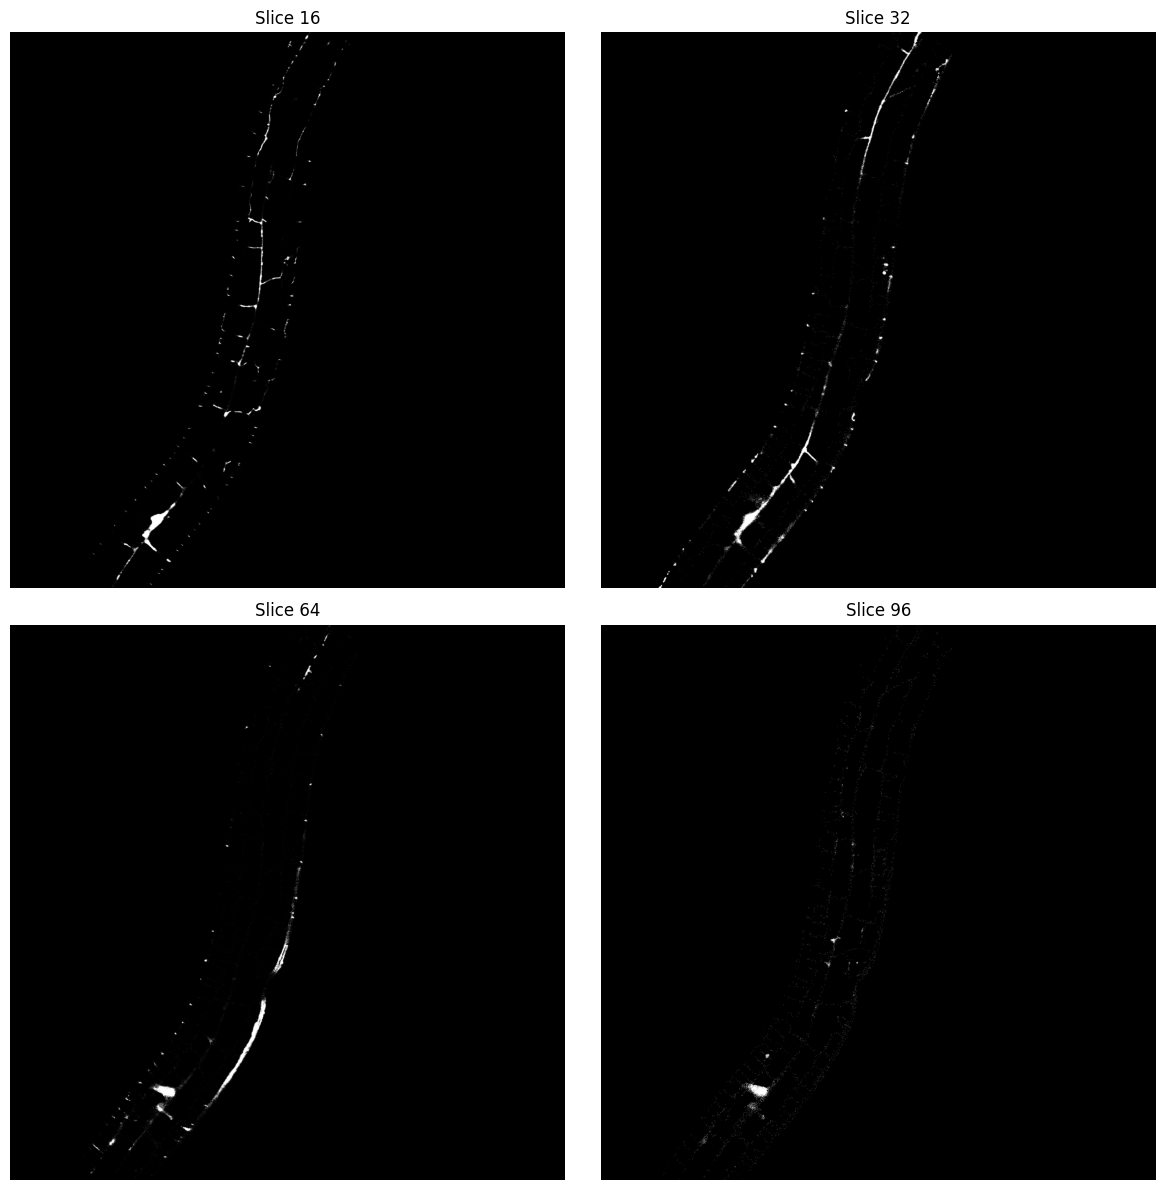

In [258]:
visualize_slices(masked_stack, preview_slices)

In [259]:
thresh_stack = process_stack(masked_stack, threshold_slice, threshold=64, min_size=4)

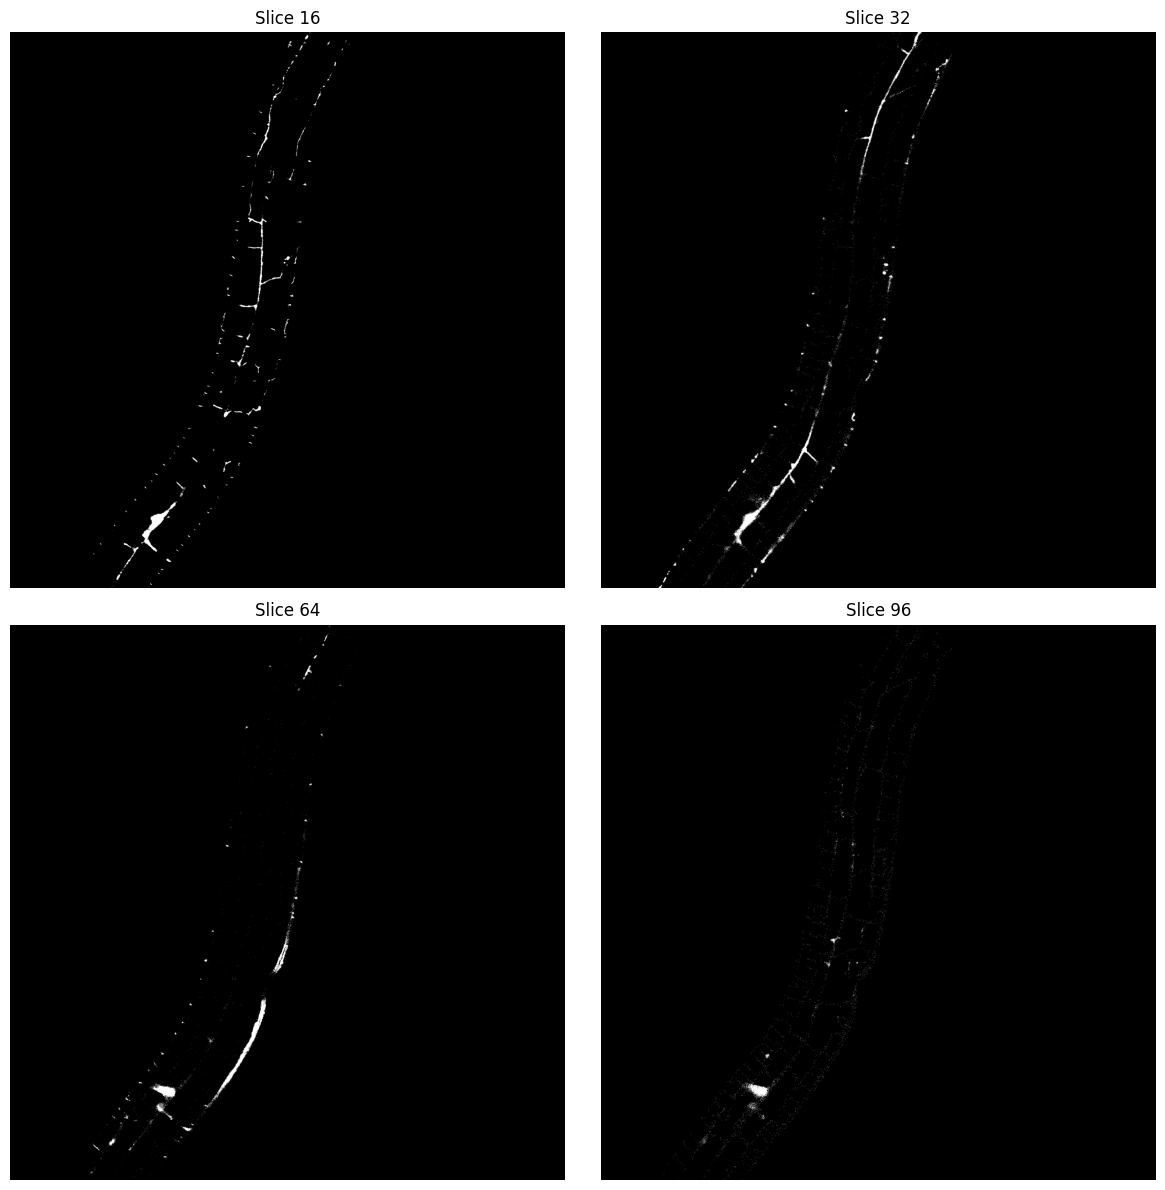

In [260]:
visualize_slices(thresh_stack, preview_slices)

### Remove Floating Regions

In [261]:
from scipy.ndimage import binary_erosion, binary_dilation

# Define a structuring element (3x3x3 cube)
structuring_element = np.ones((3, 3, 3), dtype=bool)

# Perform erosion followed by dilation (opening)
opened_array = binary_dilation(binary_erosion(thresh_stack, structure=structuring_element), structure=structuring_element)


In [262]:
from scipy.ndimage import label

def filter_fuzzy_regions(image):
    labeled, num_features = label(image)
    output = np.zeros_like(image)

    # Analyze each region
    for i in range(1, num_features + 1):
        region = (labeled == i)
        if np.mean(region[image == 1]) > 0.95 or np.mean(region[image == 0]) > 0.95:
            output[region] = image[region]

    return output

In [263]:
# Remove fuzzy regions from each slice
#thresh_stack = process_stack(thresh_stack, filter_fuzzy_regions)

In [264]:
# Try removing small objects on full 3d stack
thresh_stack = morphology.remove_small_objects(thresh_stack > 0, min_size=48000, connectivity=26) # 6 = face connectivity, 18 = face + edge, 26 = face + edge + corner

In [265]:
#opened_array = morphology.remove_small_objects(opened_array > 0, min_size=48000, connectivity=26) # 6 = face connectivity, 18 = face + edge, 26 = face + edge + corner

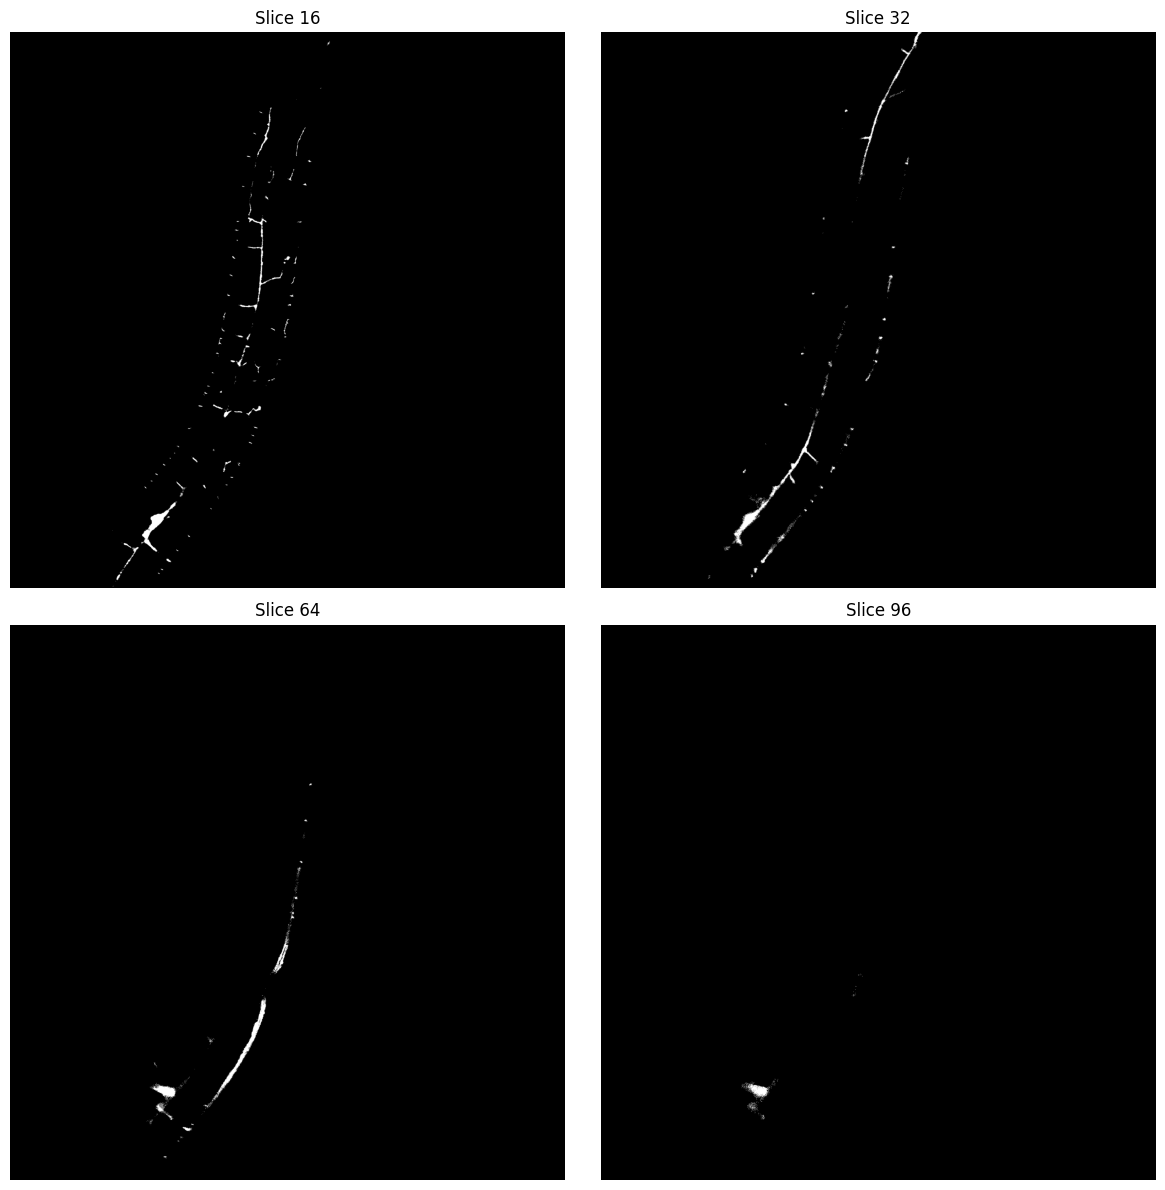

In [266]:
visualize_slices(thresh_stack, preview_slices)

In [267]:
# Convert bool to uint8
thresh_stack = thresh_stack.astype(np.uint8)
np.amax(thresh_stack)

1

In [268]:
# Convert bool to uint8
opened_array = thresh_stack.astype(np.uint8)
np.amax(opened_array)

1

In [269]:
print(np.mean(thresh_stack))
print(np.mean(opened_array))

0.0015491941881519851
0.0015491941881519851


In [270]:
import tifffile as tiff
# Write the TIFF stack
tiff.imwrite(f'output/thresh_stack_{timepoint}.tif', thresh_stack, imagej=True)

np.save(f'output/pvd_binary_{timepoint}.npy', thresh_stack)


In [271]:
# Write the MIP mask
tiff.imwrite(f'output/mip_mask_{timepoint}.tif', mip_mask, imagej=True)

np.save(f'output/mip_mask_{timepoint}.npy', mip_mask)

ValueError: the ImageJ format does not support data type '?'